# First let's import the modules

In [1]:
from math import sqrt, log, pi

from numpy.random import randn
from numpy.matlib import repmat
from scipy.stats import norm
from scipy.optimize import fmin
from scipy.special import erf
import pandas as pd
import numpy as np

from matplotlib import pyplot

# Now for our logit prediction function

In [2]:
def ll(beta, y, x):
    pred_prob = norm.cdf(np.matmul(x, beta))

    pred_prob_log = np.log(pred_prob)
    inverse_y = (1 - y)
    inverse_log_pred_prob = np.log(1 - pred_prob)

    s = (y * pred_prob_log) + (inverse_y * inverse_log_pred_prob)
    loglikelihood = np.sum(s)

    sigma = 1
    npdf = norm.pdf(beta / sigma)

    return loglikelihood + np.sum(np.log(npdf))


def predicted_probability(y, x):
    guess = np.zeros((x.shape[1], 1))
    # Maximise the values for the logit
    betahat = fmin(lambda beta, y, x: -ll(beta, y, x), x0=guess, args=(y, x), maxiter=5000)
    return norm.cdf(np.matmul(x, betahat))


# Now we generate the data and simulate the outcome...

In [6]:
"""
-- K is the number of variables on the CV; Respondents is the number of firms (set to 1 for an example now); Options is the number of CVs to be assessed.
-- Params are the 'true' weights that are being attached to each of the K characteristics by each firm.
-- y is a 'yes/no' decision (binary) on whether they say that they would or would not interview each intern.
-- EstPredictedProb is a separate function that estimates a probit, firm by firm, and then predicts the probabilities.
-- The last line ('scatter') is just visualising the 'true' probability of interview against the estimated probability.
-- If you dig into EstPredictedProb and then ProbitLL, you will see the last term of LL -- i.e this is where I'm imposing the prior on the parameters, by way of a penalty 
"""


K = 5; # Number of variables on CV
Respondents = 1; # Number of open jobs
Options = 50; # Number of job seekers

# %% First, draw parameters...

Params = randn(Respondents, K) # True weights for CV variables
ID = 1 # Dunno
BigParams = repmat(Params, Options, 1)
BigID = repmat(ID, Options, 1)


# %% Second, draw data...
x = randn(Respondents * Options, K)
x[:, 0] = 1

# %% Third, simulate the outcome...
xhat = np.sum(np.multiply(x, BigParams), axis=1)
trueprob = norm.cdf(xhat)
epsilon = randn(Respondents * Options, 1).reshape(Options)

y = (xhat + epsilon >= 0) # True/False table on whether firm will interview candidate

K = 5;
Respondents = 1;
Options = 50;

# %% First, draw parameters...

Params = randn(Respondents, K)
ID = 1
BigParams = repmat(Params, Options, 1)
BigID = repmat(ID, Options, 1)


# %% Second, draw data...
x = randn(Respondents * Options, K)
x[:, 0] = 1

# %% Third, simulate the outcome...
xhat = np.sum(np.multiply(x, BigParams), axis=1)
trueprob = norm.cdf(xhat)
epsilon = randn(Respondents * Options, 1)

y = (xhat + epsilon >= 0)


# And now let's run the prediction

Optimization terminated successfully.
         Current function value: 1052.799238
         Iterations: 364
         Function evaluations: 596


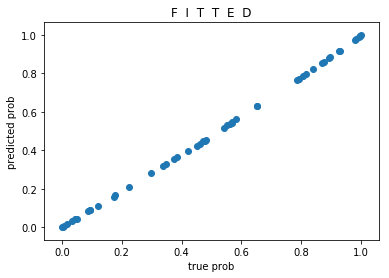

In [13]:
# %% Fourth, estimate...
predprob = np.empty((Respondents * Options, 1))
predprob[:] = np.nan

for count in range(Respondents):
    yy = y
    xx = x[:]
    newprob = predicted_probability(
        yy,
        xx
    )
    predprob = newprob

pyplot.scatter(trueprob, predprob)
pyplot.xlabel('true prob')
pyplot.ylabel('predicted prob')
pyplot.title('F  I  T  T  E  D')
pyplot.show()
